In [2]:
### SAME imports as Xu's fixed version

from desc.transform import Transform
from desc.equilibrium import Equilibrium
from desc.basis import ChebyshevZernikeBasis, chebyshev_z
from desc.compute import compute
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid, Grid
from desc.compute.utils import get_transforms
from desc.objectives import (
    FixEndCapLambda,
    FixEndCapR,
    FixEndCapZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixIota,
    ForceBalance,
    ObjectiveFunction,
    CurrentDensity,
)
import numpy as np
from desc.optimize import Optimizer
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface
from scipy.constants import mu_0


def chebygrid(N_grid):
    return np.concatenate(
        (
            [0],
            (-np.cos((2 * np.arange(N_grid) + 1) * np.pi / (2 * N_grid)) + 1) * np.pi,
            [2 * np.pi],
        )
    )


def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid, M=M_grid, N=0, node_pattern=node_pattern).nodes[
        :, :2
    ]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size, 1))
    n = np.tile(Nnodes.reshape(-1, 1), (1, LMnodes.shape[0])).reshape(-1, 1)
    nodes = np.concatenate((lm, n), axis=1)

    # RG: weights and spacing defined here
    # just for the sake of compilation. Must be checked
    weights = np.ones(nodes.shape[0])
    spacing = np.ones_like(nodes)

    spacing[1:, 1] = np.diff(nodes[:, 1])
    spacing[1:, 2] = np.diff(nodes[:, 2])

    return Grid(nodes, spacing=spacing, weights=weights)


def get_lm_mode(basis, coeff, zeta, L, M, func_zeta=chebyshev_z):
    modes = basis.modes
    lm = 0
    for i, (l, m, n) in enumerate(modes):
        if l == L and m == M:
            lm += func_zeta(zeta, n) * coeff[i]
    return lm

In [5]:
from desc.objectives import (
    SurfaceQuadraticFlux,
    ToroidalFlux,
    ObjectiveFunction,
)
from desc.magnetic_fields import SplineMagneticField
from desc.geometry import FourierRZToroidalSurface
from desc.optimize import Optimizer
from desc.grid import LinearGrid
from desc.plotting import plot_2d, poincare_plot, plot_boundary, plot_surfaces
import numpy as np

In [7]:
from desc.coils import MixedCoilSet

In [8]:
field = MixedCoilSet.from_makegrid_coilfile("smola_coils_unscaled.coils")

In [10]:
# extcur = [4700.0, 1000.0]
# ext_field = SplineMagneticField.from_mgrid(
#    "../../../tests/inputs/mgrid_test.nc", extcur=extcur
# )
# extcur = [1.0]
# field = SplineMagneticField.from_mgrid(
#    "simple_mirror_MR_9.mgrid", extcur=extcur
# )

In [14]:
grid = grid_gen(2, 5, 10)

In [16]:
surface0 = FourierRZToroidalSurface(
    R_lmn=[0, 1, -0.5],
    modes_R=[[0, 0], [1, 0], [1, 2]],
    Z_lmn=[0, -1, 0.5],
    modes_Z=[[0, 0], [-1, 0], [-1, 2]],
    NFP=1,
    sym=False,
    mirror=True,
)

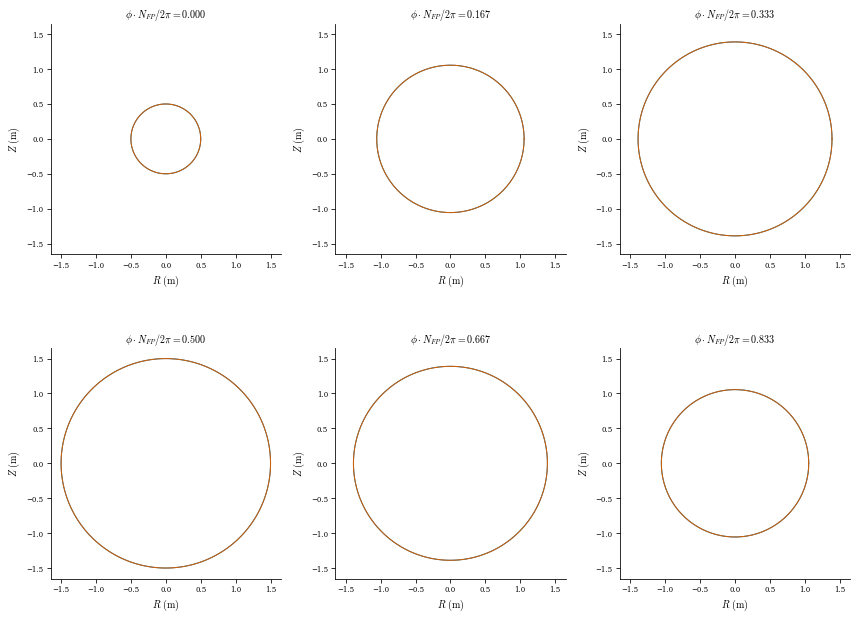

In [18]:
fig, ax = plot_surfaces(surface0, rho=1.0, theta=0)

In [20]:
# SurfaceQuadraticFlux objective is the one to use when trying to minimize quadratic flux for a surface
qflux = SurfaceQuadraticFlux(
    surface0,
    field,
    # eval_grid=LinearGrid(M=2 * surface0.M, N=2 * surface0.M, NFP=surface0.NFP),
    eval_grid=grid,
    field_fixed=True,  # field is not being optimized
    bs_chunk_size=10,
)

In [ ]:
# Must include a ToroidalFlux or a Volume target to ensure we don't get a trivial solution of the surface collapsing to a point
target_psi = 6
tflux = ToroidalFlux(
    surface0,
    field,
    target=target_psi,  # the same toroidal flux as used in the free bdry eq
    eq_fixed=False,  # we will allow the thing passed in (QFM surface in this case) to vary
    field_fixed=True,  # field is not being optimized, so we fix it
)
obj = ObjectiveFunction(qflux)

opt = Optimizer("lsq-auglag")

(qfm_surf,), _ = opt.optimize(
    surface0,
    objective=obj,
    constraints=(tflux,),
    ftol=1e-5,
    maxiter=100,
    verbose=3,
    copy=True,
)

Building objective: Surface Quadratic Flux
Precomputing transforms
Timer: Precomputing transforms = 600 ms
Timer: Objective build = 614 ms
Building objective: toroidal-flux
Precomputing transforms
Timer: Precomputing transforms = 214 ms
Timer: Objective build = 1.59 sec
Number of parameters: 18
Number of objectives: 192
Number of equality constraints: 1
Number of inequality constraints: 0
Timer: Initializing the optimization = 2.27 sec

Starting optimization
Using method: lsq-auglag


In [ ]:
# grid = LinearGrid(M=2 * surface0.M, N=2 * surface0.M, NFP=surface0.NFP)

In [ ]:
data = qfm_surf.compute(["X", "Y", "Z"], grid=grid)

In [ ]:
surf_data = surface0.compute(["X", "Y", "Z"], grid=grid)

In [ ]:
coil_data = field.compute(["X", "Y", "Z"])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for coils in coil_data:
    x = coils["X"]
    y = coils["Y"]
    z = coils["Z"]
    plt.plot(z, x)

In [ ]:
x = surf_data["X"]
y = surf_data["Y"]
z = surf_data["Z"]
plt.plot(z, x, ".")

In [ ]:
x = data["X"]
y = data["Y"]
z = data["Z"]
plt.plot(z, x, ".")

In [ ]:
from mayavi import mlab

In [117]:
fig = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(0.0, 0.0, 0.0))

for coils in coil_data:
    x = coils["X"]
    y = coils["Y"]
    z = coils["Z"]
    points = mlab.points3d(
        x, y, z, scale_factor=0.1, scale_mode="none", color=(0, 0, 1)
    )


x = surf_data["X"]
y = surf_data["Y"]
z = surf_data["Z"]
points = mlab.points3d(x, y, z, scale_factor=0.1, color=(1, 0, 0))


x = data["X"]
y = data["Y"]
z = data["Z"]
points = mlab.points3d(x, y, z, scale_factor=0.1, scale_mode="none")

# mlab.colorbar()


mlab.show()

In [82]:
### Now make a vaccum eq
surface = qfm_surf.copy()

In [85]:
# import first or else jupyter crashes

from desc.plotting import plot_section
from desc.plotting import (
    plot_grid,
    plot_boozer_modes,
    plot_boozer_surface,
    plot_qs_error,
    plot_boundaries,
    plot_boundary,
)
import desc
import matplotlib.pyplot as plt
from desc.basis import ChebyshevFourierSeries


from desc.transform import Transform
from desc.equilibrium import Equilibrium
from desc.basis import ChebyshevZernikeBasis, chebyshev_z
from desc.compute import compute
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid, Grid
from desc.compute.utils import get_transforms
from desc.objectives import (
    FixEndCapLambda,
    FixEndCapR,
    FixEndCapZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixIota,
    ForceBalance,
    ObjectiveFunction,
    CurrentDensity,
    MatchEndCapR,
    MatchEndCapZ,
    MatchEndCapLambda,
    ForceBalanceAnisotropic,
    MagneticWell,
    FixAnisotropy,
)
import numpy as np
from desc.optimize import Optimizer
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface
from scipy.constants import mu_0
from mayavi import mlab


def chebygrid(N_grid):
    return np.concatenate(
        (
            [0],
            (-np.cos((2 * np.arange(N_grid) + 1) * np.pi / (2 * N_grid)) + 1) * np.pi,
            [2 * np.pi],
        )
    )


def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid, M=M_grid, N=0, node_pattern=node_pattern).nodes[
        :, :2
    ]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size, 1))
    n = np.tile(Nnodes.reshape(-1, 1), (1, LMnodes.shape[0])).reshape(-1, 1)
    nodes = np.concatenate((lm, n), axis=1)

    # RG: weights and spacing defined here
    # just for the sake of compilation. Must be checked
    weights = np.ones(nodes.shape[0])
    spacing = np.ones_like(nodes)

    spacing[1:, 1] = np.diff(nodes[:, 1])
    spacing[1:, 2] = np.diff(nodes[:, 2])

    return Grid(nodes, spacing=spacing, weights=weights)


def get_lm_mode(basis, coeff, zeta, L, M, func_zeta=chebyshev_z):
    modes = basis.modes
    lm = 0
    for i, (l, m, n) in enumerate(modes):
        if l == L and m == M:
            lm += func_zeta(zeta, n) * coeff[i]
    return lm


plt.rcParams.update(
    {
        "font.size": 16,  # Default text size
        "axes.titlesize": 18,  # Title font
        "axes.labelsize": 16,  # x/y label font
        "xtick.labelsize": 14,  # Tick font
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    }
)


p = PowerSeriesProfile(params=[0.001 / mu_0, -0.001 / mu_0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0.0, 0])

In [87]:
p.set_params(0, a=0e6)  # = array([-1000])
p.set_params(2, a=-0e6)  # = array([-1000])

In [89]:
surface._length

Array(62.83185307, dtype=float64)

In [91]:
eq = Equilibrium(
    surface=surface,
    L=5,
    M=2,
    N=12,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
)

In [93]:
eq_start = eq.copy()

Text(0.5, 1.0, 'MR = 6.381878212116186')

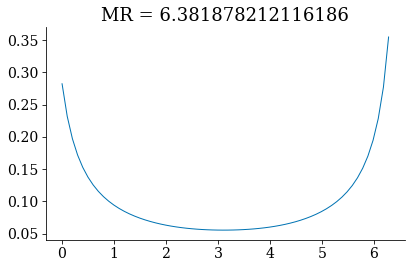

In [113]:
# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
zeta_axis = np.linspace(0, 2 * np.pi, 64)
rho_axis = np.zeros_like(zeta_axis)
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(["|B|", "p", "beta_a", "Y"], grid=grid_axis)
B_axis = data_axis["|B|"]
p_perp_axis = data_axis["p"]

plt.figure()
plt.plot(zeta_axis, B_axis)
plt.title("MR = {}".format(np.max(B_axis) / np.min(B_axis)))

In [109]:
constraints = (
    # FixEndCapLambda(0, eq=eq),
    # FixEndCapR(0, eq=eq),
    # FixEndCapZ(0, eq=eq),
    # FixEndCapLambda(2*np.pi, eq=eq),
    # FixEndCapR(2*np.pi, eq=eq),
    # FixEndCapZ(2*np.pi, eq=eq),
    MatchEndCapR(eq=eq),
    # MatchEndCapZ(eq=eq),
    MatchEndCapLambda(eq=eq),
    # EndCapMatchLambda_Rot(eq=eq),
    # EndCapMatchR_Rot(eq=eq),
    # EndCapMatchZ_Rot(eq=eq),
    # FixBoundaryR(eq=eq),
    FixBoundaryZ(eq=eq),
    FixPressure(eq=eq),
    FixIota(eq=eq),
    FixPsi(eq=eq),
    # FixAnisotropy(eq=eq),
)
optimizer = Optimizer("lsq-exact")
grid = grid_gen(10, 20, 20)


# objectives = CurrentDensity(eq=eq, grid=grid)
# objectives = ForceBalance(eq=eq, grid=grid)
# objectives = [ForceBalance(eq=eq, grid=grid), 100.0 * symmetry_obj]
# obj = ObjectiveFunction(objectives=objectives)
# force_obj = ForceBalanceAnisotropic(eq=eq, grid=grid)
# obj = ObjectiveFunction(objectives=[force_obj])

aFB = ForceBalance(eq=eq, grid=grid)

stab = MagneticWell(eq=eq)
obj = ObjectiveFunction(objectives=[aFB])

eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-8,
    xtol=1e-16,
    gtol=1e-16,
    maxiter=20,
    verbose=3,
)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 199 ms
Timer: Objective build = 228 ms
Building objective: MatchR at Endcaps
Building objective: MatchL at Endcaps
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 71.7 ms
Timer: LinearConstraintProjection build = 60.7 ms
Number of parameters: 380
Number of objectives: 6072
Timer: Initializing the optimization = 367 ms

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.506e-01                                    1.530e-01   
       1              5          2.921e-01      5.851e-02      1.414e

(Equilibrium at 0x321b99d10 (L=5, M=2, N=12, NFP=1, sym=False, spectral_indexing=ansi),
           message: Maximum number of iterations has been exceeded.
           success: False
               fun: [-9.641e-04  3.881e-06 ... -7.360e-03 -4.953e-03]
                 x: [-8.908e-01  2.790e+00 ...  5.372e-02  7.637e-02]
               nit: 20
              cost: 0.021566193673738434
                 v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
        optimality: 0.01560047528363624
              nfev: 27
              njev: 21
              allx: [Array([ 9.870e+00, -1.746e+00, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.871e+00, -1.760e+00, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.873e+00, -1.767e+00, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.875e+00, -1.778e+00, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.876e+00, -1

In [111]:
f = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)

print(f"Force error after eq.solve(): {f:.4e}")

Force error after eq.solve(): 1.5337e-02


In [105]:
from desc.plotting import *

(<Figure size 1080.81x720.54 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axe

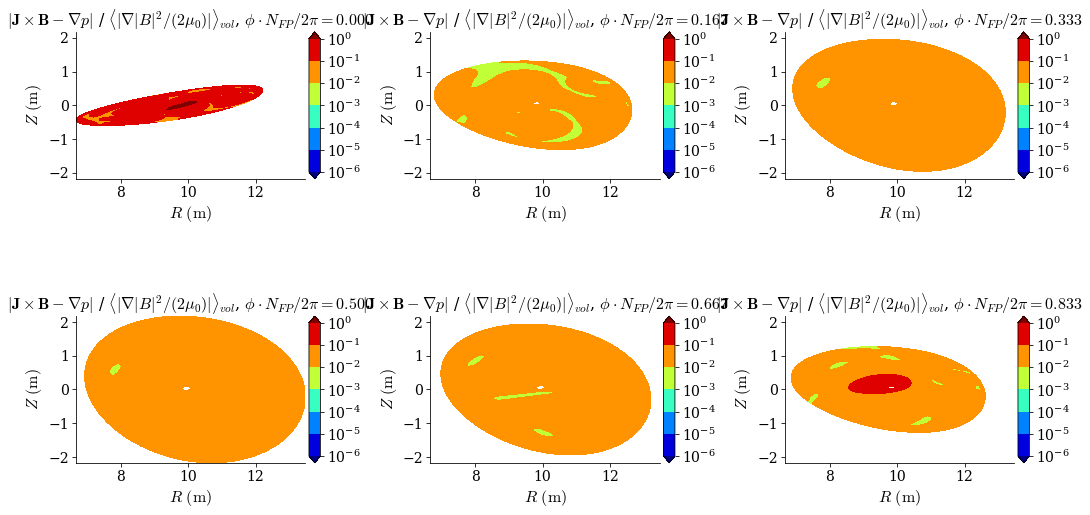

In [107]:
plot_section(eq, "|F|", norm_F=True, log=True)